# Clean up

Cleaning up code for future me & testing if things worked

In [1]:
# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
import warnings

from tqdm import tqdm
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from io_utils import *
from plotting_utils import * 


# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")
# sns.set_palette('RdBu')

Test with single session

In [2]:
sess_name =  'data_sdc_20190902_145404_fromSD' 
base_path  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'


# create paths
sess_path = os.path.join(base_path, sess_name)
beh_path  = os.path.join(sess_path, beh_mat)
spks_path = os.path.join(sess_path, spks_mat)


## Delay L/R

In [4]:
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=False)

hit_df = beh_df[beh_df['hit_hist'] == 'hit']

sess_aligned, sess_windows = event_align_session(spks_dict, hit_df, sess_path, 
                                                 overwrite=False, delay_mode=True, 
                                                 file_name='2021_05_14_hit_only.pkl')

loading from file...


TODO: make this into a plot with a seabron swarm plot to go with!

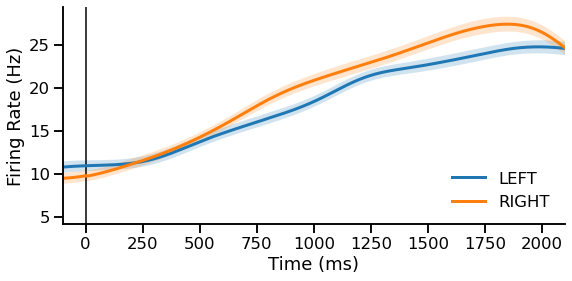

In [68]:
n = 0
g1 = PSTH_gaussain(sess_aligned[n], sess_windows[n], 'delay_overlap', hit_df, 
                  conditions='correct_side', sigma=150)


fig, ax = plt.subplots(1,1, figsize=(9,4))
plot_psth(g1, xlim=(-100,2100), legend=True, error=True)

In [69]:
from statsmodels.stats.weightstats import ttest_ind
l = d.query('condition == "LEFT"')['firing_rate']
r = d.query('condition == "RIGHT"')['firing_rate']
_, pval, _ = ttest_ind(l.dropna(),r.dropna())

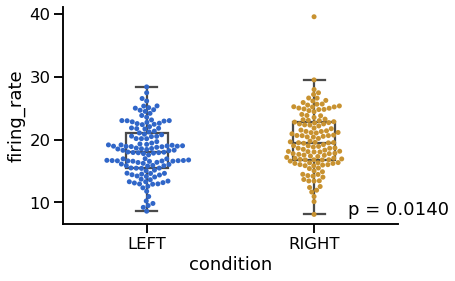

In [70]:
d = fr_by_condition_df(g1, '111kk', loudness=False)
lr_pal = ['#3066C8', '#C89230']
ax = sns.boxplot(x='condition', y='firing_rate', data=d, width=0.25, showfliers=False, 
                 boxprops={'facecolor':'none'}, palette=lr_pal)
ax = sns.swarmplot(x='condition', y='firing_rate', data=d, palette=lr_pal)

ax.text(1.2, d['firing_rate'].min(), f"p = {pval:0.4f}")
        
sns.despine()

1      1.370445
2      6.084891
3      1.549082
4      1.148841
5      3.811008
         ...   
123    2.884863
124    5.027063
125    0.686145
126    2.463187
128    3.590101
Name: firing_rate, Length: 125, dtype: float64

In [12]:
def fr_by_condition_df(psth, neuron_id, loudness=True):

    """
    Create df with average firing rate information by first sound loudness for
     further plotting/analysis

    params:
    -------
    psth      : dict, output from psth_gaussain() or psth_boxcar() with firing rate
                information
    neuron_id : str, session data and neuron idx for labeling

    returns
    -------
    df        : df, n trials long with first sound loduness and average firing
                rate during delay period"""

    conds = []
    mean_fr_by_cond = []

    for key in psth['data'].keys():
        for trial_psth in psth['data'][key]:
            
            # convert from str to float if using for regression
            if loudness:
                conds.append(float(key.replace('*','')))
            else:
                conds.append(key)

            # get mean for each trial during only the delay period
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                mean_fr_by_cond.append(np.nanmean(trial_psth[600:-600]))

    ids = [neuron_id] * len(conds)

    df = pd.DataFrame({'firing_rate' : mean_fr_by_cond, 'condition' : conds, 'neuron_id' : ids})

    return df

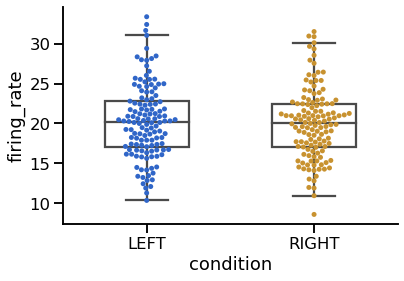

In [23]:
d = fr_by_condition_df(g1, '111kk', loudness=False)
lr_pal = ['#3066C8', '#C89230']
ax = sns.boxplot(x='condition', y='firing_rate', data=d, width=0.5, showfliers=False, 
                 boxprops={'facecolor':'none'}, palette=lr_pal)
ax = sns.swarmplot(x='condition', y='firing_rate', data=d, palette=lr_pal)

sns.despine()

## Delay Loudness

Load in

In [3]:
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=False)

filtered_df = beh_df[(beh_df['first_sound'] != 'psycho') & (beh_df['hit_hist'] == 'hit')]

sess_aligned, sess_windows = event_align_session(spks_dict, filtered_df, sess_path, overwrite=False,
                                                delay_mode=True, file_name='2021_05_06_cleanup_aligned_spks.pkl')
fig_save_path = os.path.join(os.getcwd(), 'figures', 'cleanup')

loading from file...


In [27]:
beh_df

,trial_num,hit_hist,delay,pair_hist,correct_side,prev_side,aud1_sigma,aud2_sigma,c_poke,end_state,hit_state,aud1_on,aud1_off,aud2_on,aud2_off,louder,first_sound
18,19,hit,4,5,LEFT,LEFT,0.001000,0.002700,638.592225,645.952226,644.708217,638.643221,639.043233,643.043224,643.442229,aud_2,60*
19,20,hit,6,5,LEFT,LEFT,0.001000,0.002700,652.103221,661.256217,659.849224,652.154222,652.553231,658.553227,658.953227,aud_2,60*
21,22,hit,2,1,RIGHT,RIGHT,0.002700,0.001000,672.617221,677.762223,676.540220,672.667224,673.067227,675.067231,675.467238,aud_1,68
22,23,hit,2,1,RIGHT,RIGHT,0.002700,0.001000,684.046215,689.180224,687.884237,684.096224,684.496236,686.496224,686.896231,aud_1,68
23,24,hit,4,8,LEFT,RIGHT,0.019683,0.053144,694.376218,701.768215,700.364220,694.426220,694.826222,698.826221,699.226219,aud_2,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,398,hit,6,13,LEFT,RIGHT,0.004023,0.007300,5184.165229,5193.525236,5192.218219,5184.216224,5184.616224,5190.615234,5191.015235,psycho,psycho
398,399,hit,6,8,LEFT,LEFT,0.019683,0.053144,5200.459223,5209.354228,5208.175221,5200.509224,5200.909224,5206.909227,5207.309225,aud_2,84
400,401,hit,2,2,RIGHT,LEFT,0.007290,0.002700,5227.210220,5232.558223,5231.212228,5227.260225,5227.660226,5229.661221,5230.061221,aud_1,76
401,402,hit,2,12,LEFT,RIGHT,0.002704,0.007300,5241.322233,5246.522218,5245.159224,5241.373230,5241.773230,5243.773224,5244.173227,psycho,psycho


In [101]:
analyze_and_plot_loudness(
                          sess_name, 
                          sess_aligned, 
                          sess_windows, 
                          event='delay_overlap', 
                          df=filtered_df, 
                          fig_save_path=fig_save_path, 
                          sess_path=sess_path
                         )

Plotting data_sdc_20190902_145404_fromSD_N0
Plotting data_sdc_20190902_145404_fromSD_N1
Plotting data_sdc_20190902_145404_fromSD_N2
Plotting data_sdc_20190902_145404_fromSD_N3


In [113]:
n = 0
g = PSTH_gaussain(sess_aligned[n], sess_windows[n], 'delay_overlap', filtered_df, 
                  conditions='first_sound', sigma=150)


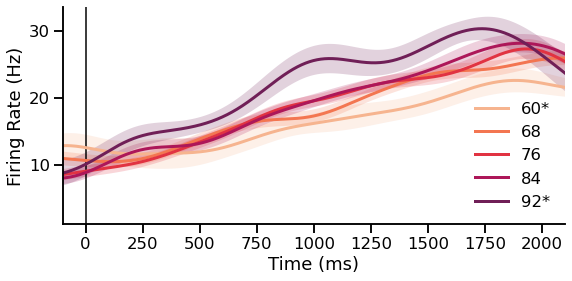

In [114]:
sns.set_palette('rocket_r')
# pal = sns.color_palette('rocket_r', 5)
# pal.as_hex()
fig, ax = plt.subplots(1,1, figsize=(9,4))
plot_psth(g, xlim=(-100,2100), legend=True, error=True)

In [ ]:
sns.set_palette('rocket_r')
# pal = sns.color_palette('rocket_r', 5)
# pal.as_hex()
fig, ax = plt.subplots(1,1, figsize=(9,4))
plot_(g, xlim=(-300,2300), legend=True, error=True)

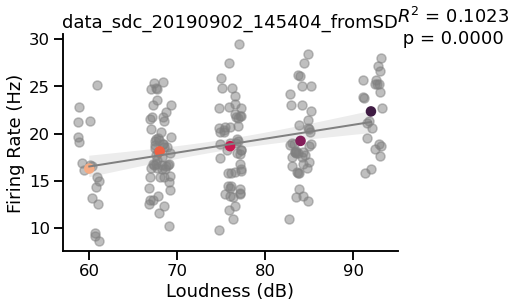

In [79]:
loudness_df = fr_by_loudness_df(g, sess_name)
regression_stats = regress_loudness_and_plot(loudness_df)

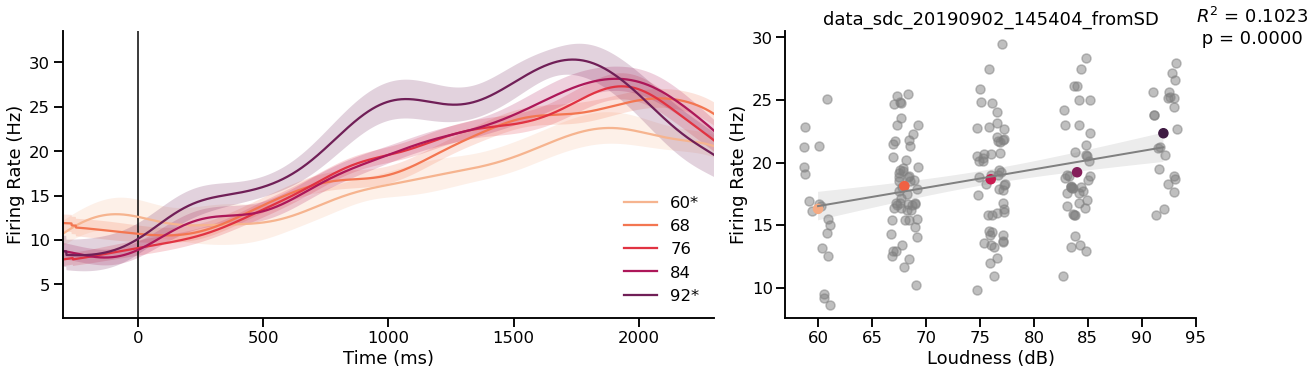

In [96]:
fig = plt.figure(figsize=(17,5))
ax1 = plt.subplot2grid((2,5), (0,0), rowspan=2, colspan=3)
ax2 = plt.subplot2grid((2,5), (0,3), rowspan=2, colspan=2)
plt.tight_layout()

plot_psth(g, xlim=(-300,2300), axis=ax1, legend=True, error=True)
regression_stats = regress_loudness_and_plot(loudness_df, ax=ax2)
plt.savefig('loudness_plot', bbox_inches='tight')

Now make a plot for both of them using grid spec

## CLASS stuff

In [48]:
sess_aligned[0].keys()

dict_keys(['aud1on', 'aud1off', 'aud2on', 'aud2off', 'trial_all', 'delay_overlap', 'delay2s', 'trial2s', 'delay4s', 'trial4s'])

In [59]:
class Trial():
    def __init__(self,dval):
        self.delay=dval
        return None

        
trial0 = Trial(2)
trial1 = Trial(4)
trial2 = Trial(4)

type(trial0)

trial0.delay,trial1.delay

trialL = [trial0,trial1]
for trial in trialL:
    print(trial.delay)

print(trial0==trial1)
print(trial1==trial2)
print(trial1)
print(trial1.delay==trial2.delay)



2
4
False
False
True


In [ ]:
class Neuron():
    def __init__(self):
        return None
    
class Trial():
    def __init__(self):
        return None

In [73]:
class Trial():
    def __init__(self,dval,sptimes):
        self.delay=dval
        self.sptimes = sptimes
        return None
    
    def get_spikes(self,thresh):
        allspikes = np.array(self.sptimes)
        spikes = allspikes[allspikes>=thresh]
        return spikes

trial10 = Trial(dval=2,sptimes = [-2,-1,0,1,2])

print('spike times relative to middle of trial',trial10.sptimes)

print('spiketimes thresholde  d',trial10.get_spikes(0))


spike times relative to middle of trial [-2, -1, 0, 1, 2]
spiketimes thresholded [0 1 2]
[0 1 2]


In [ ]:
trial10 = Trial(dval=2,sptimes = [-2,-1,0,1,2])
trial11 = Trial(dval=4,sptimes = [-12,-1,0,1,2])

trialL = [trial10,trial11]
for trial in trialL:
    if trial.delay==2:
        print(trial.get_spikes(0))

In [47]:
L = sess_aligned[neuronn]['aud1on'][trialn]
L # what was delay time (2 or 4?)

array([-0.36830063, -0.35060157, -0.34836836, -0.34046878, -0.3394355 ,
       -0.29040477, -0.28437176, -0.22484159, -0.20457601, -0.14037942,
       -0.04878429,  0.01164583,  0.05794337,  0.06460968,  0.10664078,
        0.12880627,  0.14900519,  0.16513767,  0.16783752,  0.53265146,
        0.58614861])

In [30]:
trialn = 2
neuronn= 0 
event = 'aud1on'

sess_aligned[neuronn][event][trialn]

array([-0.36830063, -0.35060157, -0.34836836, -0.34046878, -0.3394355 ,
       -0.29040477, -0.28437176, -0.22484159, -0.20457601, -0.14037942,
       -0.04878429,  0.01164583,  0.05794337,  0.06460968,  0.10664078,
        0.12880627,  0.14900519,  0.16513767,  0.16783752,  0.53265146,
        0.58614861])

In [21]:
sess_windows

{0: {'aud1on': [-400, 600],
  'aud1off': [-500, 500],
  'aud2on': [-400, 600],
  'aud2off': [-500, 500],
  'trial_all': [-100, 5000],
  'delay_overlap': [-600, 2600],
  'delay2s': [-150, 2150],
  'trial2s': [-200, 2400],
  'delay4s': [-150, 4150],
  'trial4s': [-200, 4400]},
 1: {'aud1on': [-400, 600],
  'aud1off': [-500, 500],
  'aud2on': [-400, 600],
  'aud2off': [-500, 500],
  'trial_all': [-100, 5000],
  'delay_overlap': [-600, 2600],
  'delay2s': [-150, 2150],
  'trial2s': [-200, 2400],
  'delay4s': [-150, 4150],
  'trial4s': [-200, 4400]},
 2: {'aud1on': [-400, 600],
  'aud1off': [-500, 500],
  'aud2on': [-400, 600],
  'aud2off': [-500, 500],
  'trial_all': [-100, 5000],
  'delay_overlap': [-600, 2600],
  'delay2s': [-150, 2150],
  'trial2s': [-200, 2400],
  'delay4s': [-150, 4150],
  'trial4s': [-200, 4400]},
 3: {'aud1on': [-400, 600],
  'aud1off': [-500, 500],
  'aud2on': [-400, 600],
  'aud2off': [-500, 500],
  'trial_all': [-100, 5000],
  'delay_overlap': [-600, 2600],
  'de

In [20]:
sess_windows[3]['trial_all']

[-100, 5000]

Test changes to plotting functions here with the session, save out to somewhere new.

Hits, all delay types, 'delay_overlap'